### Example of pyro.factor with Poisson

Libraries:

In [2]:
import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
from pyro.infer import MCMC, NUTS

Custom functions and models:

In [11]:
def poisson_log_pmf(lam, data):
    """Compute the log PMF for Poisson distributed data using the theoretical formula."""
    # Ensure lam and data are torch tensors
    lam = torch.tensor(lam, dtype=torch.float) if not isinstance(lam, torch.Tensor) else lam
    data = torch.tensor(data, dtype=torch.float) if not isinstance(data, torch.Tensor) else data
    # Compute the log PMF
    log_pmf = data * torch.log(lam) - lam - torch.lgamma(data + 1)
    #log_pmf=dist.Poisson(lam).log_prob(data)
    return log_pmf

        
def run_inference(model, data):
    nuts_kernel = NUTS(model)
    mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500)
    mcmc.run(data)
    samples = mcmc.get_samples()
    return samples

# (1) Model with pyro.sample
def model_PyroSample(data):
    lam = pyro.sample("lam", dist.Gamma(1.0, 1.0))  # Prior for lambda
    with pyro.plate("data", len(data)):
        pyro.sample("obs", dist.Poisson(lam), obs=data)
        
# (2) Model with pyro.factor
def model_PyroFactor(data):
    lam = pyro.sample("lam", dist.Gamma(1.0, 1.0))  # Prior for lambda
    with pyro.plate("data", len(data)):
        log_pmf = poisson_log_pmf(lam, data)
        pyro.factor("obs", log_pmf)

Define the (real)lambda parameter and generate data

In [12]:
lambda_par = torch.tensor(5.0)
data = dist.Poisson(lambda_par).sample(sample_shape=(100,))

MCMC inference:

In [13]:
samples_PyroSample = run_inference(model_PyroSample, data)
samples_PyroFactor = run_inference(model_PyroFactor, data)

Sample: 100%|██████████| 1500/1500 [00:01, 1123.32it/s, step size=1.01e+00, acc. prob=0.923]


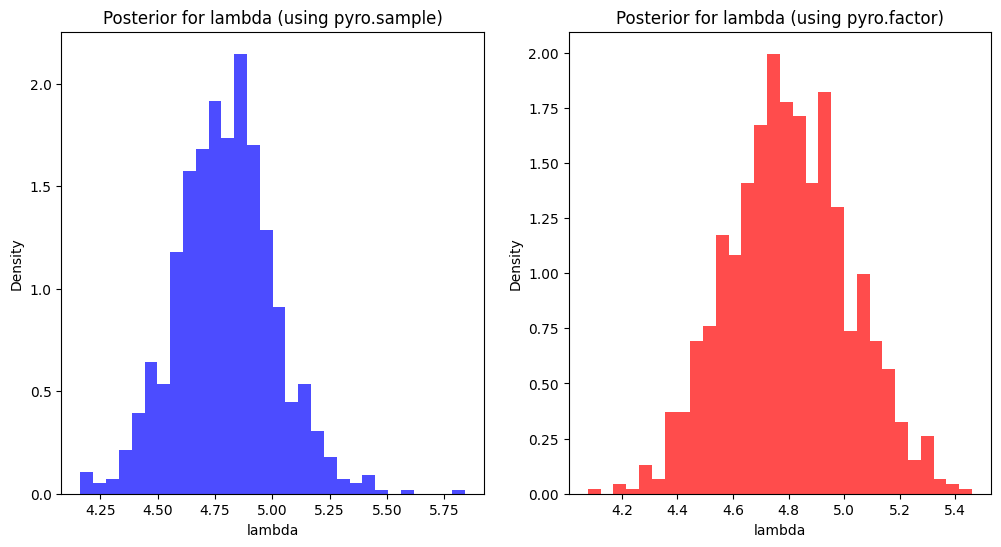

In [14]:
# Extract the lambda samples
lam_samples_1 = samples_PyroSample['lam'].detach().numpy()
lam_samples_2 = samples_PyroFactor['lam'].detach().numpy()

# Plot histograms of the samples
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(lam_samples_1, bins=30, density=True, alpha=0.7, color='blue')
plt.title('Posterior for lambda (using pyro.sample)');
plt.xlabel('lambda');
plt.ylabel('Density');

plt.subplot(1, 2, 2)
plt.hist(lam_samples_2, bins=30, density=True, alpha=0.7, color='red')
plt.title('Posterior for lambda (using pyro.factor)');
plt.xlabel('lambda');
plt.ylabel('Density');